In [1]:
import numpy as np
import enum
from fxpmath import Fxp
import cmath
import math
import commpy as cpy
import matplotlib.pyplot as plot
import scipy.io

In [2]:
    frameNr=40
    M=32
    K=4
    Nsub=600
    Concurrence = 1
    
    n_int =16
    n_frac =10
    n_word = n_int+n_frac
    i_int =4
    i_frac =12
    i_word = i_int+i_frac
    class OFDMSymbolType(enum.Enum):
        SYNC = 1
        ULP = 2
        ULD = 3
        GUARD = 4
        DLP = 5
        DLD = 6
  #  frameSchedule = [OFDMSymbolType.ULP, OFDMSymbolType.ULD, OFDMSymbolType.ULD, OFDMSymbolType.GUARD, 
  #                 OFDMSymbolType.DLP, OFDMSymbolType.DLD, OFDMSymbolType.DLD]
    frameSchedule = [OFDMSymbolType.ULP, OFDMSymbolType.ULD, OFDMSymbolType.ULD]


In [3]:
mat = scipy.io.loadmat('matlab.mat')
#mat = scipy.io.loadmat('channels_pyf.mat')
mat = np.array(mat['channels_write'])
#normalization
factor_raw = 0
for k in range(0,Nsub):
    factor_raw = factor_raw + np.square(np.linalg.norm(mat[k,:,:]))
factor = 1/np.sqrt(factor_raw/(M*K*Nsub))
H_norm = np.full_like(mat,0)
for k in range(0,Nsub):
    for i in range(0,M):
        for j in range(0,K):
            H_norm[k,i,j] = mat[k,i,j]*factor

In [4]:
# variable initlization
OFDMSymbolCounter = 0
SubcarrierCounter = 0
OFDMSymbolCounter_gen = 0
SubcarrierCounter_gen = 0
H_gen = [None]*(Nsub//(K*Concurrence))
currentSymbolType = OFDMSymbolType.SYNC
detMatrixCounterStore = 0
detMatrixCounterFetch = 0
#Hest = np.array([[Fxp(0+0j,True,n_word,n_frac) for _ in range(K)] for _ in range(M)])


#detMatrixMemory = np.array([[Fxp(0+0j, True, n_word,n_frac) for _ in range(M)] for _ in range(Nsub)])
Hest = np.array([[0+0j for _ in range(K)] for _ in range(M)])
detMatrixMemory = np.array([[0+0j for _ in range(M)] for _ in range(Nsub)])


In [5]:
# system specification
def frame_init():
    global qpsk
    global pilots_symbol
    global pilots_lut
    global H_gen
    global data_bits_a,data_bits_b,data_symbol_a,data_symbol_b
    pilots_symbol = np.zeros((Nsub//(K*Concurrence),K),dtype=complex)
    pilots_bits = np.random.binomial(n=1,p=0.5,size=(Nsub//(K*Concurrence),K*2))
    qpsk = cpy.QAMModem(4)
    for i in range(0,Nsub//(K*Concurrence)):
        pilots_symbol[i,:]=np.array(qpsk.modulate(pilots_bits[i,:])/math.sqrt(2))
    pilots_symbol = np.pad(pilots_symbol,[(0,0),(0,K*(Concurrence-1))],mode='constant',constant_values=0+0j).reshape(Nsub)
    pilots_bits=np.pad(pilots_bits,[(0,0),(0,2*K*(Concurrence-1))],mode='constant',constant_values=0).reshape(2*Nsub)
    #pilots_lut = Fxp(pilots_symbol,True,n_word,n_frac)
    pilots_lut = pilots_symbol
    for i in range(0,Nsub//(K*Concurrence)):
        
        H_gen[i] = H_norm[i*K*Concurrence,:,:]
    

In [6]:
def channelprocessing():
    global H_gen
    global OFDMSymbolCounter_gen
    global SubcarrierCounter_gen
    global pilots_symbol
    inputVector = np.zeros((M,1),dtype=complex)
    dataVector = np.zeros((K,1),dtype=complex)
    if SubcarrierCounter_gen == Nsub:
        OFDMSymbolCounter_gen = OFDMSymbolCounter_gen + 1
        if OFDMSymbolCounter_gen == 3:
            OFDMSymbolCounter_gen = 0
        SubcarrierCounter_gen = 0
    currentSymbolType_gen = frameSchedule[OFDMSymbolCounter_gen]
    H_use = H_norm[SubcarrierCounter_gen,:,:]

    if currentSymbolType_gen == OFDMSymbolType.ULP:
        pilotVector = np.zeros((K,1),dtype=complex)
        pilotVector[SubcarrierCounter_gen % K,0] = pilots_symbol[SubcarrierCounter_gen]
        inputVector = np.dot(H_use,pilotVector)
    if currentSymbolType_gen == OFDMSymbolType.ULD:
        if OFDMSymbolCounter_gen == 1:
            dataVector[:,0] = data_symbol_a[:,SubcarrierCounter_gen]
        else:
            dataVector[:,0] = data_symbol_b[:,SubcarrierCounter_gen]
        inputVector = np.dot(H_use,dataVector)       
    SubcarrierCounter_gen = SubcarrierCounter_gen + 1
    return inputVector

    

In [7]:


def flowcontrol(inputVector):
    global OFDMSymbolCounter
    global SubcarrierCounter
    global currentSymbolType
    currentSymbolType = frameSchedule[OFDMSymbolCounter]
    tmpSubcarrierCounter = SubcarrierCounter
    SubcarrierCounter = SubcarrierCounter + 1
    if SubcarrierCounter == Nsub:
        SubcarrierCounter = 0
        OFDMSymbolCounter = OFDMSymbolCounter + 1
        if OFDMSymbolCounter == len(frameSchedule):
            OFDMSymbolCounter = 0
    return tmpSubcarrierCounter, currentSymbolType

In [8]:
def ce(inputVector, tmpSubcarrierCounter, currentSymbolType):
    
    global detMatrixCounterStore
    global Hest
    global pilots_lut
    global detMatrixMemory
    
    inputVector = Fxp(inputVector,True,i_word,i_frac)
    if currentSymbolType == OFDMSymbolType.ULP:
        subcarriersModUsers = tmpSubcarrierCounter % (K*Concurrence)
        if subcarriersModUsers < K:
            for i in range(0,M):
                tmpPilot = pilots_lut[tmpSubcarrierCounter];
                Hest[i, subcarriersModUsers] = inputVector[i]*(tmpPilot.conj());

        if subcarriersModUsers == K-1:
            detMatrix = np.array([[Fxp(0+0j,True,n_word,n_frac) for _ in range(M)] for _ in range(K)])
            G = np.array([[Fxp(0+0j,True,n_word,n_frac) for _ in range(K)] for _ in range(K)])
            Ginv = np.array([[Fxp(0+0j,True,n_word,n_frac) for _ in range(K)] for _ in range(K)])
            HestHermitian = np.array([[Fxp(0+0j,True,n_word,n_frac) for _ in range(M)] for _ in range(K)])
            #detMatrix = np.array([[0+0j for _ in range(M)] for _ in range(K)])
            #G = np.array([[0+0j for _ in range(K)] for _ in range(K)])
            #Ginv = np.array([[0+0j for _ in range(K)] for _ in range(K)])
            #HestHermitian = np.array([[0+0j for _ in range(M)] for _ in range(K)])
            for cols in range(0,K):
                for rows in range(0,M):
                    HestHermitian[cols,rows] = Fxp(Hest[rows,cols].conj(),True,n_word,n_frac)
                    #HestHermitian[cols,rows] = Hest[rows,cols].conj()
            G = Fxp(np.dot(HestHermitian, Hest),True,n_word,n_frac)
            Ginv = Fxp(np.linalg.inv(G),True,n_word,n_frac)
            detMatrix = Fxp(np.dot(Ginv, HestHermitian),True,n_word,n_frac)

            #G = np.dot(HestHermitian, Hest)
            #Ginv = np.linalg.inv(G)
            #detMatrix = np.dot(Ginv, HestHermitian)
            #detMatrix = Fxp(np.dot(Ginv, HestHermitian),True,n_word,n_frac)

            for cols in range(0, K):
                for rows in range(0,M):
                     detMatrixMemory[detMatrixCounterStore*K+cols,rows] = detMatrix[cols,rows]
            detMatrixCounterStore = detMatrixCounterStore + 1;
            if detMatrixCounterStore == Nsub/(K*Concurrence):
                detMatrixCounterStore = 0
 
            
        
    

In [9]:
def detection(inputVector, tmpSubcarrierCounter, currentSymbolType):
    global detMatrixCounterFetch
    #inputVector = Fxp(inputVector,True,16,10)
    if currentSymbolType == OFDMSymbolType.ULD:
        subcarriersModUsers = tmpSubcarrierCounter % K
        #detMatrix = np.array([[Fxp(0+0j,True,n_word,n_frac) for _ in range(M)] for _ in range(K)])
        detMatrix = np.array([[0+0j for _ in range(M)] for _ in range(K)])
        for cols in range(0,K):
            for rows in range(0,M):
                detMatrix[cols, rows] = detMatrixMemory[detMatrixCounterFetch*K+cols, rows]
        detMatrixCounterFetch = math.floor((tmpSubcarrierCounter+1)/(K*Concurrence))
        if detMatrixCounterFetch == Nsub/(K*Concurrence):
            detMatrixCounterFetch = 0
        #detectedVector = Fxp(np.dot(detMatrix,inputVector),True,i_word,i_frac)
        detectedVector = np.dot(detMatrix,inputVector)
        return detectedVector

In [10]:

data_bits=0
SNR_array = np.arange(0,40,1)

BER_array = np.zeros((len(SNR_array),K))
frameFactor = frameNr//len(SNR_array)

qam = cpy.QAMModem(16)
num_bit_errors = np.zeros(K)
acc_num_bit_errors = np.zeros(K)


for j in range(0,frameNr):
    print(j)
    frame_init()
    target_snr_db =  SNR_array[j//frameFactor]
    data_bits_a = np.random.binomial(n=1,p=0.5,size = (Nsub*K*4))
    data_bits_b = np.random.binomial(n=1,p=0.5,size = (Nsub*K*4))
    data_symbol_a = np.array(qam.modulate(data_bits_a)/math.sqrt(10)).reshape(K,Nsub)
    data_symbol_b = np.array(qam.modulate(data_bits_b)/math.sqrt(10)).reshape(K,Nsub)
    data_symbol2_a = np.zeros((K,Nsub),dtype=complex)
    data_symbol2_b = np.zeros((K,Nsub),dtype=complex)


    data_bits_a = data_bits_a.reshape(K,4*Nsub)
    data_bits_b = data_bits_b.reshape(K,4*Nsub)
    data_bits2_a = np.zeros((K,Nsub*4),dtype = int)
    data_bits2_b = np.zeros((K,Nsub*4),dtype = int)

    data_symbol2_a = np.zeros((K,Nsub),dtype=complex)
    data_symbol2_b = np.zeros((K,Nsub),dtype=complex)
    for i in range(0,Nsub*3): 
        inputVector1 = channelprocessing()
        [tmpSubcarrierCounter, currentSymbolType] = flowcontrol(inputVector1)
        inputVector_n = inputVector1;
        if currentSymbolType == OFDMSymbolType.ULD:
            signal_power = 10*np.log10(np.square(np.linalg.norm(inputVector1)))
            noise_power = 10**((signal_power - target_snr_db)/10)
            noise = np.random.normal(0, 1, size=(M,2)).view(complex)
            noise_real_power = np.square(np.linalg.norm(noise))
            noise1 = noise*np.sqrt(noise_power/noise_real_power)
            inputVector_n = inputVector1 + noise1

        ce(inputVector1,tmpSubcarrierCounter, currentSymbolType)
        detectedVector = detection(inputVector_n,tmpSubcarrierCounter, currentSymbolType)
        if currentSymbolType == OFDMSymbolType.ULD:
            if i in range(Nsub,Nsub*2):
                data_symbol2_a[:,[i-Nsub,i-Nsub]] = detectedVector
            else:
                data_symbol2_b[:,[i-Nsub*2,i-Nsub*2]] = detectedVector
    #data_symbol2_a = data_symbol2_a.reshape(Nsub*K)
    for k in range(0,K):
        data_bits2_a[k,:] = qam.demodulate(data_symbol2_a[k,:]*math.sqrt(10),'hard')
        eee= cpy.utilities.hamming_dist(data_bits_a[k,:],data_bits2_a[k,:])

        num_bit_errors[k]  = eee
        acc_num_bit_errors[k] = acc_num_bit_errors[k] + num_bit_errors[k]


    #data_symbol2_b = data_symbol2_b.reshape(Nsub*K)
    for k in range(0,K):
        data_bits2_b[k,:] = qam.demodulate(data_symbol2_b[k,:]*math.sqrt(10),'hard')
        num_bit_errors[k] = cpy.utilities.hamming_dist(data_bits_b[k,:],data_bits2_b[k,:])
        acc_num_bit_errors[k] = acc_num_bit_errors[k] + num_bit_errors[k]
    data_bits=data_bits+data_bits_a.size+data_bits_b.size
    if (j+1)%frameFactor == 0:
        BER_array[j//frameFactor] = K*acc_num_bit_errors/data_bits

        acc_num_bit_errors = np.zeros(K)
        data_bits = 0



0
1
2
3
4
5
6
7
8
9


KeyboardInterrupt: 

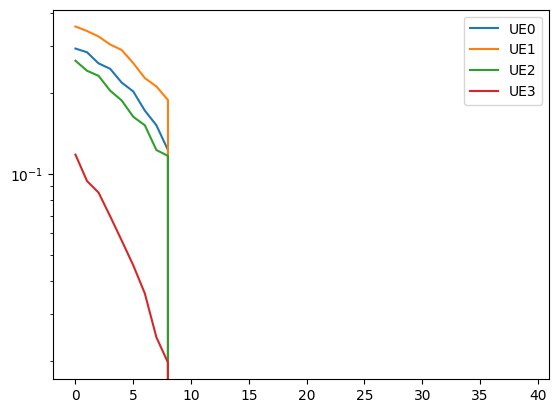

In [11]:
plot.semilogy(SNR_array,BER_array[:,0],label="UE0")
plot.semilogy(SNR_array,BER_array[:,1],label="UE1")
plot.semilogy(SNR_array,BER_array[:,2],label="UE2")
plot.semilogy(SNR_array,BER_array[:,3],label="UE3")
plot.legend(loc="best")